# Project Overview
This notebook serves as a demonstration of various machine learning models for classification on non-linearly separable data. It's important to note that this notebook will not cover data transformations that enable linear separation on multiple planes. This notebook will server more to understand and go over machine learning algorithms.

The dataset used in this notebook consists of two categories that cannot be linearly separated. Our objective is to find a model that yields the best classification results for these categories. To achieve this, I will use several classification algorithms such as logistic regression, k-nearest neighbors, decision trees, random forests and support vector machines. For each of the models I will analyze their performance. Before implementing and evaluating these algorithms, I will provide a explanation of how each one works and discuss their limitations.

Within each algorithm section, I will present the results and provide an interpretation of their meaning and quality. Additionally, at the end of the notebook, I will compare the performance of the different algorithms and determine which ones are most effective for solving this classification problem.

So let's dive into the project. We will begin by importing all the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, auc
import seaborn as sns
from sklearn.model_selection import train_test_split

# Loading Data
 The data was generated using the `make_moons` function from the `sklearn` library. To make this more interesting I introduced some noise during the dataset creation process. This adds a layer of complexity and makes the modeling process more intriguing.

To understand the specific details of how the dataset was created, you can refer to the notebook in this repository called `make_dataset.ipynb`. Each model will have its advantages and limitations which we will uncover in this notebook. In the meantime lets laod the data.

In [2]:
data_path = './data'

In [3]:
X_train = pd.read_csv(f'{data_path}/X_train.csv').values
y_train = pd.read_csv(f'{data_path}/y_train.csv').values
X_test = pd.read_csv(f'{data_path}/X_test.csv').values
y_test = pd.read_csv(f'{data_path}/y_test.csv').values

In [4]:
X_train

array([[ 1.54379532, -0.24240855],
       [ 0.28436209, -0.289493  ],
       [-0.81890549,  0.05312903],
       ...,
       [ 1.12097316, -0.33904545],
       [ 0.80314786,  0.69590775],
       [-0.50533898,  1.08899138]], shape=(1125, 2))

In [5]:
y_train

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]], shape=(1125, 1))

# Graphing the Data
Down below is some code for graphing the data. First we want to seperate the data by class/output. Doing this will allow us to graph our data with different colors to see the different classes. 

Below is a graph of our data. As we can see there are two classes. One can be seen in blue and the other one in red. We can also see that it is not linearly seperable. This means that there is not some line we can draw to clearly seperate them. This could be possible if we did some transformation on our data but in this notebook we will skip that.

Another thing to mention is that we can see that the data is a bit noisy. By that I mean that we can see that these classes overlap each other at some parts. Some examples are even surronded by different classes. Making our data noisy makes modeling and analysing more interesting but more difficult. This is dataset is still relatively clean. In real datasets the data will be a lot noisy.

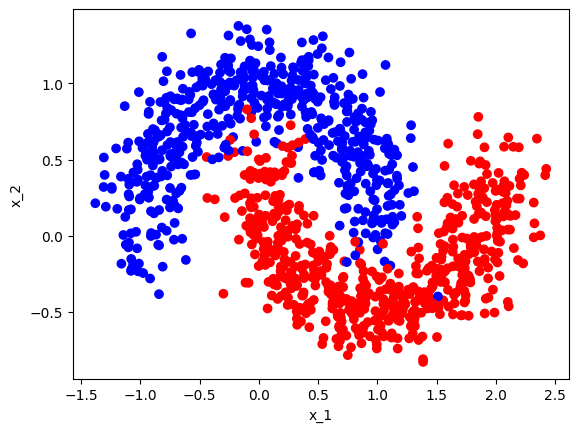

In [6]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr',) 
plt.xlabel('x_1')
plt.ylabel('x_2')
plt.show();

Below are some functions ive defined to plot the decision boundary and roc curve of each model. We will go over what that means later in the notebook. 

In [7]:
def plot_decision_boundary(clf, X, y, title="Decision Boundary", resolution=300):
    if X.shape[1] != 2:
        raise ValueError("X must have exactly 2 features to plot decision boundary")

    # get size of the grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    # get predictions on the grid
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # plot the grid predictions
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdBu)
    # plot our actual data
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
    
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.title(title)
    plt.show()

In [8]:
def plot_roc_curve(model, X_test, y_test, title="ROC Curve"):
    # Get scores (probabilities or decision function)
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]  # use prob of class 1
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    else:
        raise ValueError("Model must support predict_proba or decision_function")
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--", label="Random chance")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

# Using Logistic Regression
The first classifcation algorithm that I will start with is logistic regression. Although regression is in the name we can use Logistic regression for binary classification. It uses the sigmoid function which is defined by:
$$ \sigma(z)= \frac{1}{1+e^{-z}} $$ 
where $$z=b_0+b_1x$$

Lets take a look at what a sigmoid curve looks.

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [10]:
x_range = np.linspace(min(X_train[:, 0])-1, max(X_train[:, 1])+1, 100) # range of x_1
y_sigmoid = sigmoid(x_range) # get sigmoid 

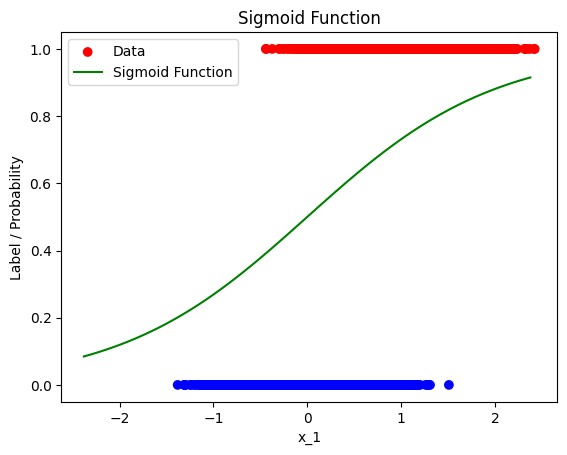

In [11]:
plt.scatter(X_train[:, 0], y_train, c=y_train, cmap='bwr', label='Data')
plt.plot(x_range, y_sigmoid, color='green', label='Sigmoid Function')
plt.xlabel("x_1")
plt.ylabel("Label / Probability")
plt.title("Sigmoid Function")
plt.legend()
plt.show()

Above we see our graph. To graph the sigmoid function we took the range of our feature `x_1` . Our feature `x_1` is plotted as well with its value on the x-axis and the label on the y axis with range 0-1. This is a simplified version of our problem since in reality we have two variables. We want to be able to plug in new variables to our sigmoid function and depending on its value if its higher than a certain threshold for example 0.5 it gets classified as class 1. 

However as we can see the curve of our sigmoid function does not fit our data well so we might not get very good predictions from it. The idea for logistic regression is to find the curve that best fits the line. To learn how we do this lets first go over how exaclty we get a prediction for our sigmoid function.

As mentioned our sigmoid function is $\sigma{(z)} = \frac{1}{1+e^{-z}}$. We previously just passed in the range of our feature $x_1$ as z but in our case $z=b_0+b_2x_2+b_1x_1$. The number of parameters $b_i$ corresponds to the number of features in our dataset. $b_0$ is some bias we add and $b_1, b_2$ are parameters we multiply by our features.

Lets go over a basic example.

In [12]:
def linear_model(x_1, x_2):
    return 0.2 + 0.1 * (x_2) + 0.2 * (x_1)

In this basic example our linear model is $z=0.2+0.1*x_2+0.2*x_1$.

In [13]:
z = linear_model(X_train[0][0], X_train[0][1])
z

np.float64(0.48451820761659103)

We pass in one sample from our dataset into the linear model and get 0.484. This is our z so now we pass it into our sigmoid function. 

In [14]:
prediction = sigmoid(z)
prediction

np.float64(0.618814214586924)

After passing it to our sigmoid function we get a value of 0.618 which if we are classifying we would output class 1.

In [15]:
y_train[0]

array([1])

This would be a correct classification as the actual class is 1. However this would not work for the many other samples in our dataset. What we want to do is find the correct values for $b_0, b_1, b_2$ that will help our sigmoid function more accuratly classify our data. We do this by ...
Now lets use the model to solve our problem!

In [16]:
from sklearn.linear_model import LogisticRegression 

In [17]:
logistic_regression = LogisticRegression()

In [18]:
logistic_regression = logistic_regression.fit(X_train, y_train.ravel())

Here are the training and the test accuracy. We can see that the scores are fairly high. Although the test score is the lowest of all these algorithms it is still a pretty high score and perfomed even higher than I thought. From these scores we can say that the model classifies most of examples in the dataset correclty but not all. 

In [19]:
f'Training Accuracy: {logistic_regression.score(X_train, y_train)}'

'Training Accuracy: 0.88'

In [20]:
f'Test Accuracy: {logistic_regression.score(X_test, y_test) }'

'Test Accuracy: 0.8746666666666667'

In [21]:
logistic_pred = logistic_regression.predict(X_test)

In [22]:
logistic_cm = confusion_matrix(y_test, logistic_pred) 

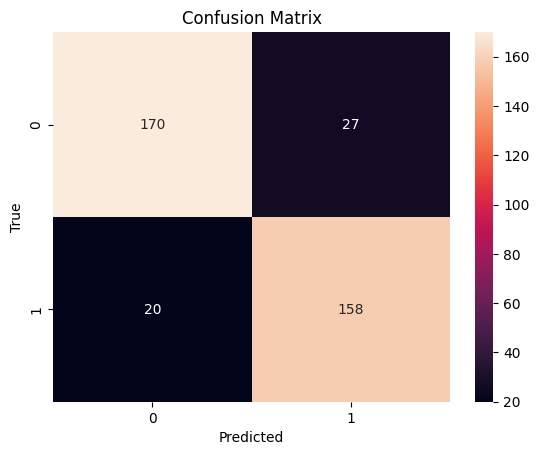

In [23]:
sns.heatmap(logistic_cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

To undertand more about the model and what it is doing there is a couple of graphs below. This will help us understand how the model is predicting and how it's making its decisions. These graphs might be confusing but I will explain what the are below. 

This is a confusion matrix. A confusion matrix can show us more into how our model is working and what it's doing. Let me break down this graph. On the `x-axis` we can see the `Predicted Label` and on the `y-axis` we can see the `True Label`. So if we take a look at the `True Label` for class `1` on the `y-axis` we can see that the `Predicted Label` for 20 of the examples was `0`. Meaning it got those 20 examples incorrect. However we can also see that for the `True Label` of class `1` the `Predicted Label` was `1` 158 times. Meaning it classified those examples correctly. As we can see this validates the statement I said about getting most examples in our training dataset correct. From this we can tell the it perfomes well and the scores are pretty good.

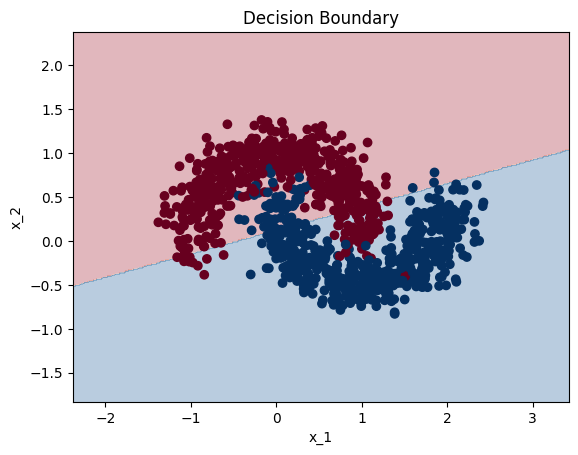

In [24]:
plot_decision_boundary(logistic_regression, X_train, y_train)

Lastly, here is a graph of the decision boundary. The decision boundary is the boundary that shows how our model is classifying data. For example here is the graph of the decision boundary for logistic regression for our problem. As we can see there is a line running through both categories/clusters. That line is what the model uses to separate and predict categories. Meaning if we want to classify a new example and it's in the blue section/below the line it will belong to that class.

We can see that the model gets the majority of the data correctly but fails to classify the middle examples. As mentioned earlier we can also see that the logistic regression decision boundary is just a line. This is because logistic regression is best for solving linearly separable problems. What this means is that if we have some data where there are two categories that we can separate and classify them by drawing a line through them. That's why the boundary here is just a line. However because this is non linearly seperable data it can't do any better than that. This is one of the limitations of logistic regression. 

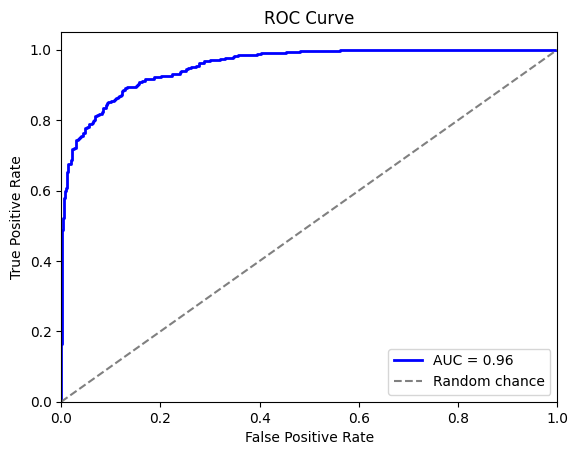

0.9551998634277115

In [25]:
plot_roc_curve(logistic_regression, X_train, y_train)

The limitations are that it can't learn the data if the data does not have a linear relationship. This can also be seen has logistic regression having a [bias error](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff). Algorithms that have a bias error are algorithms fail to learn the relationships between their datas inputs and outputs (usually underfit) and thats what logistic regression is doing here. Altough it gets a good amount of examples correct it fails to learn the edges where the data start to overlap but not fully overlap. Another reason for logistic regression having a bias error is for logistic regression making assumptions of the data. It assumes the data will be linear data which this data is not. But it did perform a lot better than I expected. 

# Using KNN
Now we will be using another classification algorithm which is knn (k nearest neighbors). The way this algorithm works is that if we want to classify something we find some odd number $k$. This odd number is the number of how many nearby examples we will check in order classify the new example. For example if our $k=3$ we will check for the three closests neighbors of our example we are trying to classify. The majority category in those three neighbors is the class that the algorithm predicts. One thing to note is that we check how close the neighbors are by taking the distance from one example to our example. A common distance is the Euclidean distance where distance equals $ d=\sqrt{(x_2-x_1)^2+(y_2-y_1)^2} $ snd $ (x_1,y_1) $ are one point and $ (x_2,y_2) $ is another point. This function returns the distance between those two points. This is how we find what is closest to our example we are trying to classify. 

In [26]:
from sklearn.neighbors import KNeighborsClassifier

A big part of `k nearest neighbors` is the hyperparameter $k$. To find the best $k$ for us we will do gridsearch which is bassically just trying a bunch of different values for $k$. We don't want to try too many just a general idea of what might be a good fit. Below I set up odd numbers 1-11 to try out. The higher numbers are just to show possible overfitting, I dont think they will perform best.

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
grid_search_knn = GridSearchCV(KNeighborsClassifier(),{
    'n_neighbors': [1, 3, 5, 7, 9, 11]
}, return_train_score=False)

In [29]:
# warning: this cell takes a long time to run
grid_search_knn.fit(X_train, y_train.ravel()) # turn to 1d array

,estimator,KNeighborsClassifier()
,param_grid,"{'n_neighbors': [1, 3, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,5


In [30]:
grid_search_knn_results = pd.DataFrame(grid_search_knn.cv_results_) 

In [31]:
grid_search_knn_results[['param_n_neighbors', 'mean_test_score']]

,param_n_neighbors,mean_test_score
0,1,0.967111
1,3,0.973333
2,5,0.978667
3,7,0.978667
4,9,0.977778
5,11,0.976889


Here is a graph of how the test score changes as our hyper parameter $k$ increases. We can see that the higher the value is the better the test score is. The biggest visual jump is from $k=1$ to $k=5$.  After that the score increases but then starts to lower. This could possibly because at those values the model starts to overfit. 

## Warning
One thing to note however is that this graph can be misleading. Although we see that as $k$ changes so does `mean_test_score` the change is so small that if we graphed it with whole numbers they would be in a sraight line with little to no difference. But because we are zoomed in it seems as though there is a drastic change. If we take a look at the dataframe we see that the mean test scores are all pretty similar. To better visualize this there is a comment below that you can remove that will plot the data if we were not zoomed in to better understand how small the change is. 

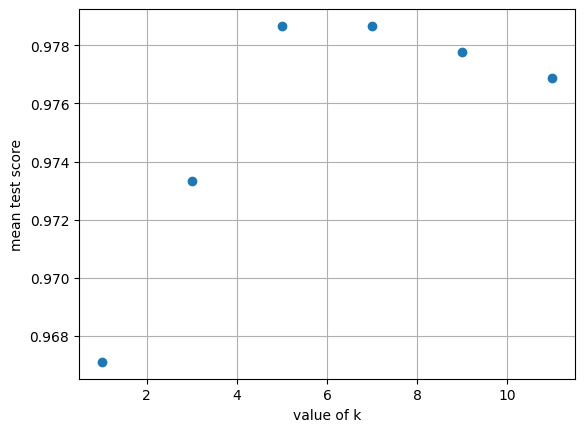

In [32]:
plt.scatter(grid_search_knn_results['param_n_neighbors'], grid_search_knn_results['mean_test_score'])
plt.xlabel('value of k')
plt.ylabel('mean test score')
plt.grid(True)
# remove the comment below to see how close these values really are
# plt.ylim(0, 1.5) 
plt.show();

In [33]:
knn = KNeighborsClassifier(n_neighbors=5)

In [34]:
knn.fit(X_train, y_train.ravel())

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [35]:
f'Test Accuracy: {knn.score(X_test, y_test)}'

'Test Accuracy: 0.9733333333333334'

In [36]:
knn_pred = knn.predict(X_test)

Our accuracy on our test data is pretty descent! To continue our evaluation of the model lets take a look at the confusion matrix.

In [37]:
knn_cm = confusion_matrix(y_test, knn_pred) 

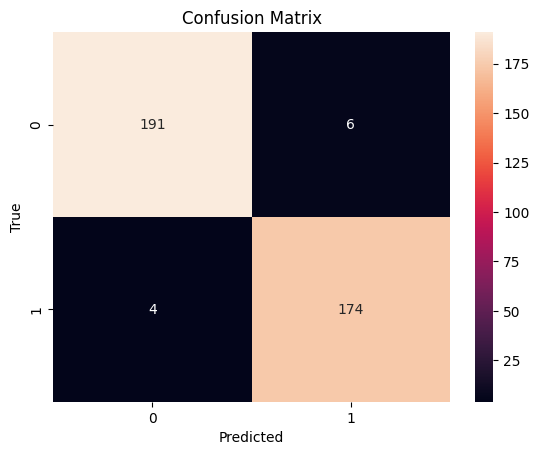

In [38]:
sns.heatmap(knn_cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Looking at the confusion matrix for this algorithm we can see that it also performs really well. It is strcitly diagonally dominant which means the predicted values classes tend to be the correct classes the false negative and false positive rates are pretty low. Now lets take at the decision boundary.

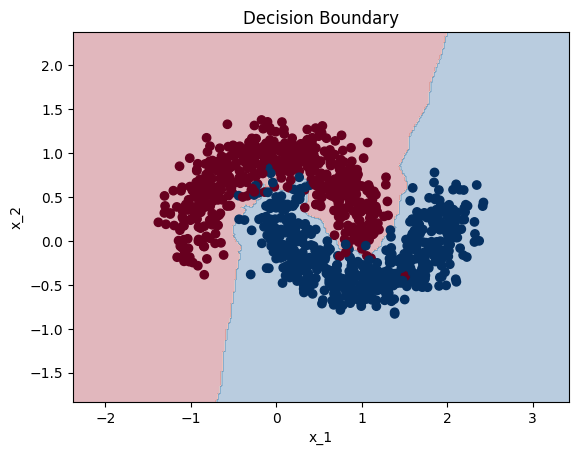

In [40]:
plot_decision_boundary(knn, X_train, y_train)

The decision boundary here is very different compared to the logistic regression one. While the logistic regression one was just a straight line through the category the decision boundary for knn has curves seperating the classes. We can see that it doesn't perfectly classify every example. But this is a good thing because if it perfectly categories everything then that means that the model is overfitting. If we overfit that means we are memorizing the training data and our model will fail  to correctly classify new examples.

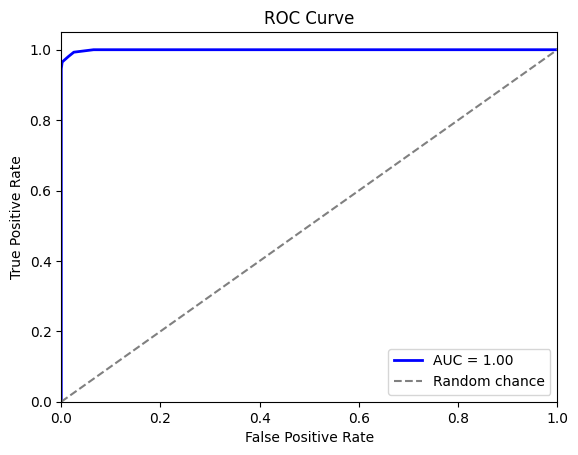

0.9992950087886796

In [41]:
plot_roc_curve(knn, X_train, y_train)

# Using Decision Trees
Another great classification algorithm is decision trees. The way this model works is the model takes in some data. The model then takes each sample and splits them all into categories. It stops until there are no more categories we can split the samples into. This can be hard to demonstrated but essentially its just a big giant if statement. So if we have a sample point of $x_1 = 4, x_2 = 3$ and belong to class 1 then we would pass our point to the model and the model would check if for example $x_1$ is equal to a number, greater or less and same for $x_2$. This will lead it to end up in s category and be able to classify it. 

In [42]:
from sklearn import tree

In [43]:
tree_clf = tree.DecisionTreeClassifier()

In [44]:
tree_clf = tree_clf.fit(X_train, y_train)

In [45]:
f'Training Accuracy: {tree_clf.score(X_train, y_train)}'

'Training Accuracy: 1.0'

The training accuracy being 1 is to be expected because it created the tree exactly with the training data. 

In [46]:
f'Test Accuracy: {tree_clf.score(X_test, y_test)}'

'Test Accuracy: 0.9706666666666667'

The test accuracy is pretty high which is a good sign! Lets look at how our model is behaving.

In [47]:
tree_pred = tree_clf.predict(X_test)

In [48]:
tree_cm = confusion_matrix(y_test, tree_pred) 

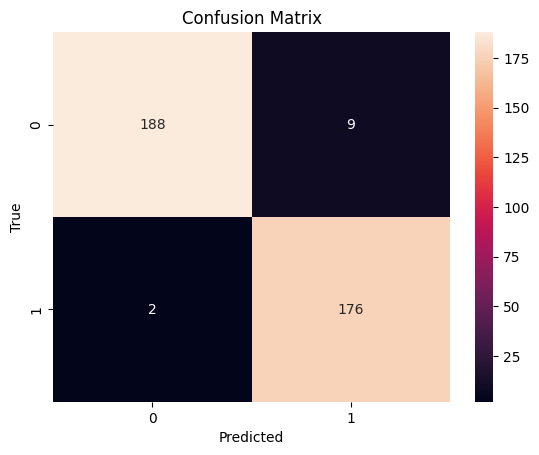

In [49]:
sns.heatmap(tree_cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

From above we can see that the confusion matrix is strictly diagonally dominant. This is a good sign because it shows that the model is often prediciting the correct class for the sample. I did notice that it predcits class 1 for class 0 more often which just means that the false positive rate is higher than the false negative rate. Its not a huge difference but its worth noting. Lets take a look at our decision boundary.

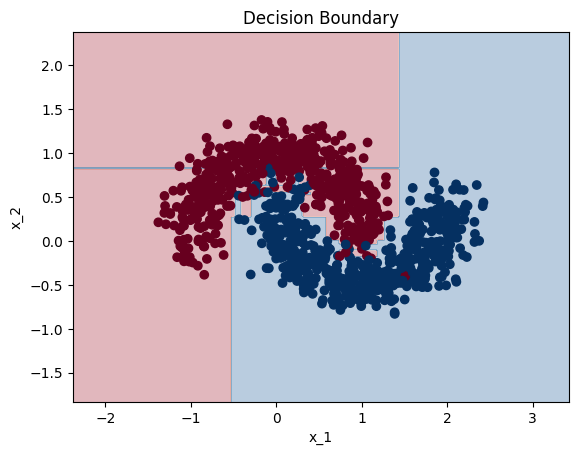

In [50]:
plot_decision_boundary(tree_clf, X_train, y_train)

As we can see the decision boundary here has no curves but rather straight lines that take turns left or right. This makes sense of course because as I mentioned earlier our algorithm breaks down everything into categories meaning it can go one way or the other and there's no in between. 

From this graph we can also tell that the model is slightly overfitting at times. We know this because there is a random blue line in the predominantly red area. Although it is overfitting it still performed really well. I don't see this being a huge problem but I could be wrong. Lets go over the ROC curve now.

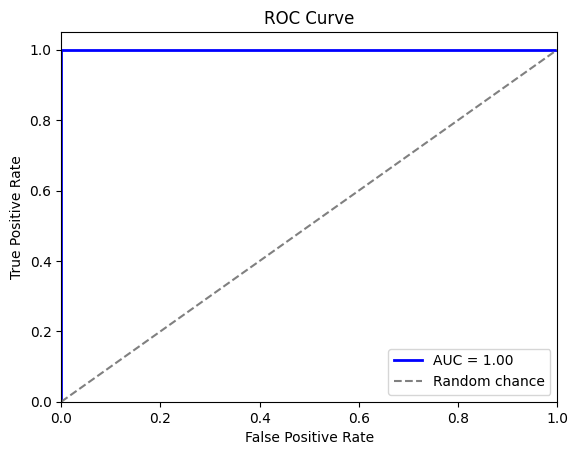

1.0

In [52]:
plot_roc_curve(tree_clf, X_train, y_train)

# Using Support Vector Machines

# Conclusion

In conclusion, although logistic regression performed better than initially expected in terms of its overall accuracy score, its inherent bias error and limitations make it unsuitable for handling this particular dataset. Its bias error prevents it from effectively learning non-linearly separable data, which is the primary objective in this case. Despite achieving a relatively high score, we know that better alternatives exist.

K Nearest Neighbors (KNN) was initially expected to be the top-performing algorithm. While it demonstrated impressive performance, it exhibited limitations due to its variance error, resulting in overfitting as observed from the decision boundary plot.

Decision trees also delivered satisfactory results, but its high variance error was evident through significant overfitting. Although it effectively classified the non-linear data, concerns arise regarding its performance with noisier data or increased class overlap. This model proved to be a suitable classifier for the non-linearly separable data, but its viability may diminish in more challenging scenarios.

Lastly, random forests were relatively unfamiliar to me at the start of this project. Initially assuming similarities to decision trees, I anticipated potential overfitting and high variance error. The ability to explore hyperparameters twice in this notebook was interesting, providing an opportunity to delve into hyperparameter optimization with multiple parameters. Ultimately, the random forests algorithm performed exceptionally well without significant overfitting, making it the most favorable solution. Unlike KNN, it did not exhibit overfitting even at the best value for the hyperparameter, k. Therefore, it is the most suitable algorithm for solving our classification problem.

All of the algorithms demonstrated strong performance in tackling the task of classifying non-linearly separable data, even including logistic regression, which initially seemed less promising. Each algorithm exhibited its own bias and variance errors and had distinct limitations, but overall, they all performed admirably. Through this project, I acquired valuable insights into machine learning algorithms, and it highlighted the importance of data transformations in enhancing logistic regression's performance. This project served as a valuable learning experience, introducing various tools for implementing machine learning algorithms, and I am excited to continue expanding my knowledge in this field.